#1 Module dependence

In [ ]:
# This notebook with 30,000,000 simulations, 10 timepoint, 2 assets is readily to run on Colab (25Gb RAM and 8Gb VRAM) - turn to GPU mode.
# Reduce the sample size accordingly. Can handle 35,000,000 but 25 Gb gets sometimes overloaded.
import numpy as np       # Data generation and operations relies on numpy
import pandas as pd      # Used for Visualization
import seaborn as sns     # Used for Visualization
import matplotlib.pyplot as plt # Used for Visualization
import keras           # Construct Neural network
import tensorflow as tf    # Construct Neural network
from sys import getsizeof   # Used to check RAM usage
import os # To support TPU computation on colab

## Custom color map

In [ ]:
# Color SETUP
# To have a better visualization, I custom a colormap.
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
cmap_name = ['BuGn','Blues','Greys','Reds','Purples','YlGn','PuBuGn','RdPu','PuBu','Oranges','YlOrBr','Reds','Blues','Purples','YlGn']
color_array = [plt.get_cmap(cmap_name[i])(range(ncolors)) for i in range(len(cmap_name))]
map_object = []
# change alpha values
for i in range(len(cmap_name)):
  color_array[i][:,-1] = np.linspace(0,1,ncolors)**0.5
  # create a colormap object
  map_object.append(LinearSegmentedColormap.from_list(name=cmap_name[i]+'_alpha',colors=color_array[i]))
  # register this new colormap with matplotlib
  plt.register_cmap(cmap=map_object[i])

 # 2 Introduction of the class `Simulation` - Simulate and Calculate Payoff


## 2.1 The usage and input froms of the build-in method - `BS_simulate()`, `Option_payoff()`
 Under the risk-neutral dynamics (with dividens), the price of assest i at time t is given by
 $$S_{t}^{i} = s_0^iexp([r - \delta_i-\sigma_i^2/2]t+\sigma_i W_t^i), i = 1,2,...,d,$$
 where $s_0^i ∈ (0, +∞ )$ is the initial price, $r \in (0, +∞ )$ is the risk-free interest rate, dividend yield $\delta_i \in [0, +∞)$, and d-dimensional Brownian motion W with constant instantaneous correlation $ρ_{ij} \in [-1,1]$ between different components $W^i, W^j$.   

 Simulations and Payoff calculation provide all the data needed for later model training, and they are included in a custom class `Simulation` as methods -- `BS_simulate` and `Payoff`(for linear payoff function), `Option_payoff`(for options including American, Bermudan Max-call.   
 The usage follows:
1. Pass the drift parameter $r$, $\delta$, diffusion parameter $\sigma$, and the correlation matrix $corr$ when initializing an instance of the class `Simulation`. In this notebook, the instance is named as `stock` Also, it is recommended to transform all the inputs to `np.float32` because these reduce RAM usage and allows more samples to be simulated..  
```python
    ''' Initialize the simulation class, with constant input.
    Input: 
      s0 - one value greater than zero
      r - risk free rate, greater than zero
      delta - D-dimension vector, account for different dividend for D assets.
      sigma - D-dimension vectosr, account for different diffusion parameter.
      amount - number of stocks/assets we hold. 
    '''
stock = Simulation(s0, r, delta, sigma, amount)  
St_arr = stock.BS_simulate(t, M, N, corr, random_state = None)
```
2. The method `BS_simulation` simulate **M** samples at **N+1** time points starting from 0 to N, for **D** underlying assest. Therefore the output shape is a (M, N+1, D) numpy array. It can haddles at most 35,000,000 samples for current PC specification: 25 Gb CPU RAM. Note that the simulated (M, N+1, D) array becomes an attribute of the instance as `stock.St_arr`, which faciliate the calculation of the payoff since we don't need to pass it as input again.
  

```python 
'''Return the spot prices at time t given by the D-dimensional B-S model, under the risk-neutral measure. 

    Input: 
      t (int) - terminal time 
      M (int) - scenarios in the sample space.
      N (int) - timepoints to discretize for interval [0,t]
      corr (ndarray) - correlation matrix of the D-dimensional wiener process, 
                the same as the covariance/correlation matrix of the underlying normal variables..

    Output:
      A 3-dimension array of the form (M,N,D),  M scenarios, N timepoints, D-assets.

'''
```  


3. The method `Option_payoff()` supports American options and Bermudan Max-Call Option to be comparable with the existing literature. Following the literature "Deep Optimal Stopping", with decision sequece specified for each path/simulation, it returns the current payoffs and continue payoff indicated by the decision sequence. As there are `M` paths, so the decision sequence should be an array of the shape `(M,N+1)`. Note that only the decision sequence from `n+1` is needed for calculating the continue payoff $g(X_{\tau_{n+1}})$, the shape constraint is added for the sake of consistance.  

For convenience, when `decision_seq = None`, the current payoff is returned. Since the custom class `Simulation` depends totally on **`Numpy`** package, it is recommended to construct this matrix as ndarray in the following way:
```python
decision_seq = np.zeros((M,N+1))
decision_seq[:,-1] = 1
decision_seq
```


In [ ]:
class Simulation (object):
  def __init__(self,s0,r,delta,sigma,amount=None):
    ''' Initialize the simulation class, with constant input.
    Input: 
      s0 - one value greater than zero
      r - risk free rate, greater than zero
      delta - D-dimension vector, account for different dividend for D assets.
      sigma - D-dimension vectosr, account for different diffusion parameter.
      amount - number of stocks/assets we hold. 
    '''
    if (len(sigma) != len(delta)):
      raise ValueError("The length of delta and sigma do not agree!")
    self.D = len(s0)
    self.amount = amount
    self.s0, self.r, self.delta, self.sigma = s0, r, delta, sigma
    self.St_arr = None
    gc.collect()
  def amount_adjust(self,new_amount):
    new_amount = np.array(new_amount)
    self.amount = new_amount

  def BS_simulate(self,t,M,N,corr,random_state = None,pandas_df = False):
    '''Return the spot prices at time t given by the D-dimensional B-S model, under the risk-neutral measure. 

    Input: 
      t - terminal time 
      M - scenarios in the sample space.
      N - timepoints to discretize for interval [0,t]
      corr - correlation matrix of the D-dimensional wiener process, the same as the covariance/correlation matrix of the underlying normal variables..

    Output:
      A 3-dimension array of the form (M,N,D),  M scenarios, N timepoints, D-assetss,
    '''
    if random_state != None:
      np.random.seed(random_state)
    D = self.D
    self.M = M
    self.N = N
    self.t = t
    self.St_arr = None
    gc.collect()
    sequence = np.arange(0,N+1).reshape((-1,1))  # A vertical sequence from 0 to N, correspoind to N time points
    time_grid = (t/N * np.tile(sequence,(M,1,D))).astype(np.float32) # Create an array for k*dt, dt = t/N, k = 0, 1, 2, ... N
    Z = np.random.multivariate_normal(np.zeros(D), corr, size=(M, N+1)).astype(np.float32)
    Z[:,0,:] = np.zeros((M,D)).astype(np.float32)
    wiener = np.cumsum(np.multiply(np.sqrt(t/N), Z,out=Z), axis = 1, out= Z).astype(np.float32)
    Z = None # Manually release RAM for Z
    # Numpy element-wise multiplication (M,N+1,D)
    # Unify the shape of drift parameter, and diffusion parameter, including the initial price
    delta = np.tile(self.delta,(M,N+1,1))
    sigma = np.tile(self.sigma,(M,N+1,1))
    s0_mat = np.tile(self.s0,(M,N+1,1)) 
    r = np.tile(self.r,(M,N+1,D)).astype(np.float32)
    drift = np.multiply(r - delta - 1/2 * sigma**2, time_grid, out=time_grid).astype(np.float32) # drift
    time_grid = None # Release RAM
    diffusion = np.multiply(sigma, wiener, out=wiener, dtype=np.float32)     # Diffusion, replace the RAM space assigned to wiener process
    sigma,delta,r,wiener = None,None,None,None # Release RAM
    exp_factor = np.exp(np.add(drift, diffusion, out=diffusion),out=diffusion, dtype=np.float32)
    drift, diffusion = None, None
    St_arr = np.multiply(s0_mat, exp_factor, out = s0_mat, dtype=np.float32) 
    s0_mat, exp_factor = None, None
    self.St_arr = St_arr
    if pandas_df == False:
      return St_arr
    else:
      df_dict = {}
      ls1 = ['s']*M 
      ls2 = list(range(1,M+1))
      col_names = list(map(lambda x: x[0] + str(x[1]), zip(ls1, ls2)))
      for d in range(D):
       df_dict[d] = pd.DataFrame(data = np.c_[np.arange(N+1), St_arr[:,:,d].T], columns= ['time']+ col_names, copy = True)
      return df_dict
    ''' Different from the cross-entrophy, where the loss is - sum[yi*logf(xi) + (1-yi)*log( 1- f(xi))] where the weight is allocated totally to one term, 
    in the paper, g(n,Xn) is essentially the weight. '''
  def IS_simulate(self,t,M,N,corr, lambda_change, random_state = None, pandas_df = False):
    '''Return the spot prices at time t given by the D-dimensional B-S model, under the risk-neutral measure. 

    Input: 
      t - terminal time 
      M - scenarios in the sample space.
      N - timepoints to discretize for interval [0,t]
      corr - correlation matrix of the D-dimensional wiener process, the same as the covariance/correlation matrix of the underlying normal variables..
      lambda_change - W_Q = W + lambda_change, this is equivalent to adjust drift by -sigma*lambda
    Output:
      A 3-dimension array of the form (M,N,D),  M scenarios, N timepoints, D-assetss,
    '''
    if random_state != None:
      np.random.seed(random_state)
    D = self.D
    self.M = M
    self.N = N
    self.t = t
    self.lambda_change = lambda_change 
    self.sample_weight = None
    self.St_arr = None
    gc.collect()
    sequence = np.arange(0,N+1).reshape((-1,1))  # A vertical sequence from 0 to N, correspoind to N time points
    time_grid = t/N * np.tile(sequence,(M,1,D)) # Create an array for k*dt, dt = t/N, k = 0, 1, 2, ... N
    Z = np.random.multivariate_normal(np.zeros(D), corr, size=(M, N+1)).astype(np.float32)
    Z[:,0,:] = np.zeros((M,D)).astype(np.float32)
    wiener = np.cumsum(np.multiply(np.sqrt(t/N), Z,out=Z), axis = 1, out= Z).astype(np.float32)
    self.wiener = wiener.copy()
    Z = None # Manually release RAM for Z
    # Numpy element-wise multiplication (M,N+1,D)
    # Unify the shape of drift parameter, and diffusion parameter, including the initial price
    delta = np.tile(self.delta,(M,N+1,1))
    sigma = np.tile(self.sigma,(M,N+1,1))
    s0_mat = np.tile(self.s0,(M,N+1,1))
    lambda_mat = np.tile(lambda_change,(M,N+1,1)).astype(np.float32)
    drift_change = (lambda_change * self.sigma).astype(np.float32)
    drift_change = np.tile(drift_change,(M,N+1,1)) # This is the drift change
    r = np.tile(self.r,(M,N+1,D)).astype(np.float32)

    drift = (np.multiply(r - delta - drift_change - 1/2 * sigma**2, time_grid, out=time_grid)).astype(np.float32) # drift
    time_grid = None # clear this name
    diffusion = np.multiply(sigma, wiener, out=wiener, dtype=np.float32)     # Diffusion, replace the RAM space assigned to wiener process
    sigma,delta,r,wiener = None,None,None,None # Release RAM
    exp_factor = np.exp(np.add(drift, diffusion, out=diffusion),out=diffusion, dtype=np.float32)
    drift, diffusion = None, None
    St_arr = np.multiply(s0_mat, exp_factor, out = s0_mat, dtype=np.float32) 
    s0_mat, exp_factor = None, None
    
    # (M, N+1, D)
    time_grid_large = t/N * np.tile(sequence, (M,1,D))
    time_grid_small = t/N * np.tile(sequence, (M,1,1))

    lambda_mat_t = np.multiply(lambda_mat, time_grid_large, out = time_grid_large).astype(np.float32)
    time_grid_large = None
    original_wiener = (self.wiener - lambda_mat_t).astype(np.float32)
    lambda_original_wiener = np.multiply(lambda_mat, original_wiener, out=original_wiener)
    sample_weight_inner = np.sum(lambda_original_wiener, axis=2, dtype = np.float32, keepdims= True) + 1/2*np.multiply(np.sum(lambda_mat**2, axis = 2, keepdims = True), time_grid_small, out = time_grid_small, dtype=np.float32)
    
    self.sample_weight = np.exp(sample_weight_inner, out = sample_weight_inner)
    self.St_arr = St_arr
    if pandas_df == False:
      return St_arr
    else:
      df_dict = {}
      ls1 = ['s']*M 
      ls2 = list(range(1,M+1))
      col_names = list(map(lambda x: x[0] + str(x[1]), zip(ls1, ls2)))
      for d in range(D):
       df_dict[d] = pd.DataFrame(data = np.c_[np.arange(N+1), St_arr[:,:,d].T], columns= ['time']+ col_names, copy = True)
      return df_dict

  def payoff(self, n, decision_seq = None, practice = False):
      '''Return current payoff and discounted continue payoff. Note that tau n is not defined as optimal stopping time, although the search of supreme will force it to converge.
      
      Input:
        n (integer): indicate the starting timepoint 
        N (integer): The number of possible stopping times (excluding 0)
        decision_seq (ndarray): of shape (M, N+1). each row takes the form (f(x0), f1(x1),...fn+1(xn+1),...,fN(xN)), of length N.
        practice (bool): Default value is False, to calculate continue payoff for loss calculation, True when the whole decision sequence is derived and the practical payoff is wanted.
      Output (ndarray):
        payoff at tau n indicated by the decison sequence.
      ''' 
      if isinstance(decision_seq,type(None)):
        current_payoff = np.sum(np.tile(self.amount,(self.M, 1)) * self.St_arr[:, n, :],axis=1)
        return current_payoff
      elif decision_seq.shape != (self.M,self.N+1):
        raise ValueError("The length of decision sequnce should be of (M,N+1)")
      else:
        if n == self.N:
          current_payoff = np.sum(np.tile(self.amount,(self.M, 1)) * self.St_arr[:, n, :], axis=1)
          return(current_payoff)
        else:
          if practice == False:
            # To calculate continue payoff, check the decision sequence from n+1
            active_decision_seq = decision_seq[:, (n+1):(self.N+1)]
            # The expression of tn is equivalent to find the index of the first nonzero element starting from n
            tn = np.argmax(active_decision_seq, axis=1) + n+1
            idx_0 = list(range(self.M))
            continue_payoff = np.exp(-self.r*tn*self.t/self.N).reshape((-1,1)) * np.sum(self.amount * self.St_arr[idx_0, tn, :],axis=1,keepdims=True)
            current_payoff = np.exp(-self.r*n*self.t/self.N).reshape((-1,1)) * np.sum(np.tile(self.amount,(self.M, 1)) * self.St_arr[:, n, :], axis=1)
            payoff = np.column_stack((current_payoff,continue_payoff))
            return payoff
          else:
            # To calculate practiced payoff, check the decision sequence from n
            active_decision_seq = decision_seq[:, n:(self.N+1)]
            # The expression of tn is equivalent to find the index of the first nonzero element starting from n
            tn = np.argmax(active_decision_seq, axis=1) + n
            idx_0 = list(range(self.M))
            practice_payoff = np.exp(-self.r*tn*self.t/self.N).reshape((-1,1)) * np.sum(self.amount * self.St_arr[idx_0, tn, :],axis=1,keepdims=True)
            return practice_payoff
  def Option_payoff(self, n: int, strike_price, decision_seq: np.ndarray = None, practice :bool = False, weighted :bool = False, option_type : str = "Bermudan"):  
    '''Return current payoff and discounted continue payoff. Note that tau n is not defined as optimal stopping time, although the search of supreme will force it to converge.
    
    Input:
      n (integer): indicate the starting timepoint
      N (integer): The number of possible stopping times (excluding 0)
      decision_seq (ndarray): of shape (M, N+1). each row takes the form (f(x0), f1(x1),...fn+1(xn+1),...,fN(xN)), of length N.
      practice (bool): Default value is False, to calculate continue payoff for loss calculation, True when the whole decision sequence is derived and the practical payoff is wanted.
    Output (ndarray):
      payoff at tau n indicated by the decison sequence.
    '''
    # Calculate current payoff without decision_seq OR precheck its dimension
    if isinstance(decision_seq, type(None)):
      current_max_spot_price = np.amax(self.St_arr[:,n,:],axis = 1,keepdims=True)
      current_payoff = np.exp(-self.r*n*self.t/self.N).reshape((-1,1)) * np.maximum(current_max_spot_price - strike_price, 0).reshape((-1,1))               
      if weighted == False:
        return current_payoff.astype(np.float32)
      else: 
        idx_0 = list(range(self.M))
        current_weight = self.sample_weight[idx_0,n].reshape((-1,1))
        return (current_weight*current_payoff).astype(np.float32)
      
    elif decision_seq.shape != (self.M,self.N+1):
      raise ValueError("The length of decision sequnce should be of (M,N+1)")
    else:
      if option_type == "Bermudan":
        if practice == False:
          # To calculate continue payoff, check the decision sequence from n+1
          active_decision_seq = decision_seq[:, (n+1):(self.N+1)]
          # The expression of tn is equivalent to find the index of the first nonzero element starting from n+1
          tn = np.argmax(active_decision_seq, axis=1) + n+1
          decision_seq, active_decision_seq = None, None # Release RAM
          
          # Maximum spot price among assets at a particular time. 
          current_max_spot_price = np.amax(self.St_arr[:,n,:], axis = 1, keepdims=True)
          # The slice the array with two list.
          idx_0 = list(range(self.M))
          continue_payoff = np.exp(-self.r*tn*self.t/self.N).reshape((-1,1)) * np.maximum(np.amax(self.St_arr[idx_0,tn,:] - strike_price, axis=1,keepdims=True),0)
          current_payoff = np.exp(-self.r*n*self.t/self.N).reshape((-1,1)) * np.maximum(current_max_spot_price - strike_price, 0)
          current_max_spot_price = None # release RAM
          payoff = np.column_stack((current_payoff,continue_payoff))
          continue_payoff, current_payoff = None, None # release RAM
          if weighted == False:
            return payoff.astype(np.float32)
          else:
            current_weight = self.sample_weight[idx_0,n].reshape((-1,1))
            continue_weight = self.sample_weight[idx_0,tn].reshape((-1,1))
            ######################I dont understand here, if I should use n or tn
            weight_mat = np.column_stack((current_weight, continue_weight))
            return (weight_mat * payoff).astype(np.float32)

        else:
          # Find the index of the first nonzero element starting from n given a fully decided decision sequence
          active_decision_seq = decision_seq[:, n:(self.N+1)]
          tn = np.argmax(active_decision_seq, axis=1) + n
          decision_seq, active_decision_seq = None, None # Release RAM
          # Maximum spot price among assets at a particular time. 
          idx_0 = list(range(self.M))
          optimal_payoff = np.exp(-self.r*tn*self.t/self.N).reshape((-1,1))*np.maximum(np.amax(self.St_arr[idx_0,tn,:] - strike_price, axis=1,keepdims=True),0)
          if weighted==False:
            return optimal_payoff.astype(np.float32)
          else: 
            optimal_weight = self.sample_weight[idx_0,tn].reshape((-1,1))
            return optimal_payoff.astype(np.float32)*optimal_weight 
 
  def payoff_all(self, strike_price, weighted = True):
    max_spot_price = np.amax(self.St_arr,axis=2,keepdims=True).copy()
    payoff = np.maximum(max_spot_price - strike_price, 0, dtype=np.float32)
    time_grid = (self.t/self.N * np.tile(np.arange(0,self.N+1).reshape((-1,1)),(self.M,1,1))).astype(np.float32)
    discounting = np.exp(-self.r*time_grid, out = time_grid, dtype = np.float32)
    payoff = np.multiply(discounting, payoff, out = payoff)
    if weighted == False:
      return payoff
    else:
      return self.sample_weight * payoff

In [ ]:
''' # exercise for Z_inv_Z
cov_mat = np.diagflat((0.1,2,5))
mat1 = np.empty((1000000,10,3),dtype=np.float32)
for i in range(0,1000000):
  mat1[i,:,:] = (1+i)*np.ones((10,3))
np.diagonal(mat1@cov_mat@np.transpose(mat1,(0,2,1)),axis1=1,axis2=2).shape
# Note the Initial S_0_arr will be replace by S0_shape_(M,D) '''

' # exercise for Z_inv_Z\ncov_mat = np.diagflat((0.1,2,5))\nmat1 = np.empty((1000000,10,3),dtype=np.float32)\nfor i in range(0,1000000):\n  mat1[i,:,:] = (1+i)*np.ones((10,3))\nnp.diagonal(mat1@cov_mat@np.transpose(mat1,(0,2,1)),axis1=1,axis2=2).shape\n# Note the Initial S_0_arr will be replace by S0_shape_(M,D) '

In [ ]:
import gc
sigma = np.array([0.2, 0.2],dtype=np.float32)
delta = np.array([0.1, 0.1],dtype=np.float32)
s0 = np.array([90, 90],dtype=np.float32)
D = len(s0) 
t = 3
r = 0.05   # Risk-free rate
N = 9
M = 30000000   
amount = np.array([1, 1])
corr = np.array([[1,0],[0,1]])
# In case this section is run again, reset stock to None to releas RAM
stock = None 
St_arr = None
gc.collect() # Garbage Collector manually to release RAM faster.
#stock = Simulation(s0, r, delta, sigma, amount)
#St_arr = stock.BS_simulate(t,M,N,corr,random_state = None)

17438

In [ ]:
gc.collect()

44

In [ ]:
IS_dict = {}
lambda_change = ((r - delta + 0.01*np.log(D))/sigma).astype(np.float32)
IS_dict['s0_IS'] = np.array([[150,150],[130,130],[160,120],[70,120],[120,70],[90,90],[45,120],[120,45],[0,90],[90,0],[10,110],[110,10],[30,120],[120,30],[60,60]],dtype=np.float32)
cluster_n = len(IS_dict['s0_IS'])
IS_dict['IS_instance'] = [Simulation(IS_dict['s0_IS'][i], r, delta, sigma, amount) for i in range(cluster_n)]
# Now use IS_simulate()
for i in range(cluster_n):
  print(f'Simulating the cluster {i+1}')
  IS_dict['IS_instance'][i].IS_simulate(t,int(M/cluster_n),N,corr,lambda_change)
  gc.collect()
# At most 30 millions 2-D simulation for 25Gb.

Simulating the cluster 1
Simulating the cluster 2
Simulating the cluster 3
Simulating the cluster 4
Simulating the cluster 5
Simulating the cluster 6
Simulating the cluster 7
Simulating the cluster 8
Simulating the cluster 9
Simulating the cluster 10
Simulating the cluster 11
Simulating the cluster 12
Simulating the cluster 13
Simulating the cluster 14
Simulating the cluster 15


In [ ]:
# Test payoff_all, and it is correct
#IS_dict['IS_instance'][7].payoff_all(100).mean(axis = 0)

In [ ]:
# 12 Millions as unseen data
M_test = 4000000
stock_BS = Simulation(s0, r, delta, sigma, amount)
St_arr_BS = stock_BS.BS_simulate(t,M_test,N,corr, random_state = None)

## 2.3 Visualization 


### Evolutions of the spot prices and the payoff
Use heatmap to show the variation of the stock price during the time horizon t∈[0,T]. While one path is a row of pixels, the brighter color means higher price according to the colorbar. 

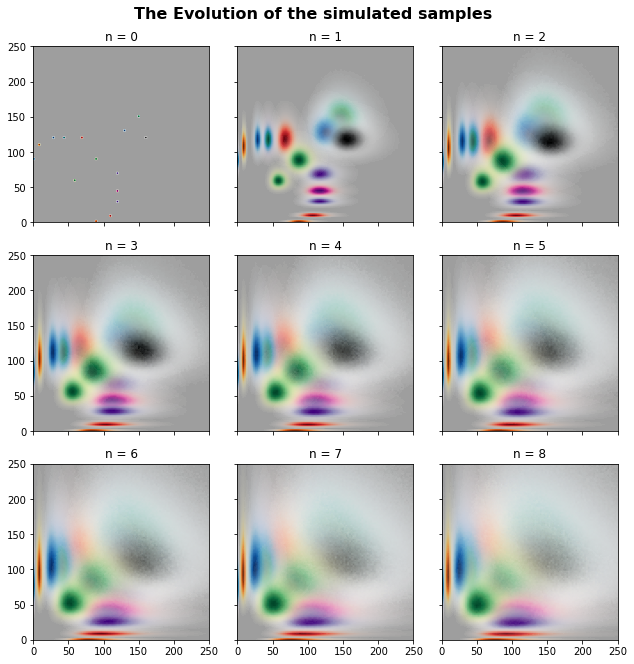

In [ ]:
fig, ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(9,9))
ax = ax.flatten()
for slice_n in range(N):
  bins = 100
  xedges = np.linspace(0,250,bins)
  yedges = np.linspace(0,250,bins)
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  # We'll also create a grey background into which the pixels will fade
  greys = np.full((bins,bins,3), 60, dtype=np.uint8)
  ax[slice_n].imshow(greys, extent=extent, alpha=0.5)
  for i in range(cluster_n):
    heatmap, xedges, yedges = np.histogram2d(IS_dict['IS_instance'][i].St_arr[:,slice_n,0], IS_dict['IS_instance'][i].St_arr[:,slice_n,1], bins=[xedges,yedges])
    h = ax[slice_n].imshow(heatmap.T, extent=extent, origin='lower',cmap = cmap_name[i]+'_alpha' ,aspect = 'equal')
    ax[slice_n].set_title(label=f'n = {slice_n}',loc='center')
fig.suptitle("The Evolution of the simulated samples", y=1.02, size=16,fontweight="bold")
plt.tight_layout()
plt.show()
    #fig.colorbar(h,ax=ax,shrink=0.5)


In [ ]:
#fig0, ax0 = plt.subplots(1,3,figsize = (12,4))
'''stock_draw = Simulation(s0, r, delta, sigma, amount)
St_arr_draw = stock_draw.BS_simulate(t,M,N,corr,random_state = None)
payoff_mat = np.zeros((M,N))
for n in range(N):
  payoff_mat[:,n] = stock_draw.Option_payoff(n = 1,strike_price = 100).reshape(-1)
sns.heatmap(St_arr_draw[:,:,0], ax = ax0[0], yticklabels=False)
ax0[0].set(xlabel='Time Point',title='Price Evolution of Asset 1 for each path')
sns.heatmap(St_arr_draw[:,:,1], ax = ax0[1],yticklabels=False)
ax0[1].set(xlabel='Time Point',title='Price Evolution of Asset 2 for each path')
sns.heatmap(payoff_mat,ax = ax0[2], yticklabels=False)
ax0[2].set(xlabel='Time Point',title='Payoff Evolution for each path')
plt.show() '''


"stock_draw = Simulation(s0, r, delta, sigma, amount)\nSt_arr_draw = stock_draw.BS_simulate(t,M,N,corr,random_state = None)\npayoff_mat = np.zeros((M,N))\nfor n in range(N):\n  payoff_mat[:,n] = stock_draw.Option_payoff(n = 1,strike_price = 100).reshape(-1)\nsns.heatmap(St_arr_draw[:,:,0], ax = ax0[0], yticklabels=False)\nax0[0].set(xlabel='Time Point',title='Price Evolution of Asset 1 for each path')\nsns.heatmap(St_arr_draw[:,:,1], ax = ax0[1],yticklabels=False)\nax0[1].set(xlabel='Time Point',title='Price Evolution of Asset 2 for each path')\nsns.heatmap(payoff_mat,ax = ax0[2], yticklabels=False)\nax0[2].set(xlabel='Time Point',title='Payoff Evolution for each path')\nplt.show() "

The average payoff for each time point `n` can be calculated using the method `Option_payoff()` specifying the `n` and the `strike_price`.

### No need to do Importance Sampling, for Markovian model, as long as the SDE is unchanged, the boundary is identical.

### Understanding the decison function in geometric sense - it is a **SHARP** boundary.
At a certain timepoint `n`, the distribution of the prices  $x = (x_1,x_2,...x_D)^T$ is also known as "Cross-sectional data".
<blockquote> 

**Cross sectional data** means that we have data from many units, at one point in time. 

**Time series data** means that we have data from one unit, over many points in time. 

**Panel data (or time series cross section)** means that we have data from many units, over many points in time.
</blockquote> 

So at a cross section, there are 3 types of data points/paths,  
<font color="blue"> (a) </font>one type of them have the same current payoff and continue payoff, therefore they make no changes to the later modelling (Zero-gradients) and are disposed before training our Neural networks since including them will make no contribution but take VRAM.   
<font color="blue"> (b) </font>The other two types are called 'Continue' and 'Stop' since these paths see strictly larger continue payoff and strictly smaller continue payoff respectively. 

### Combine the spot price information from several cluster, and their payoff (M,N+1,1)

In [ ]:
timepoint = 8
St_arr_multi= np.empty((M,N+1,2),dtype = np.float32)
payoff_multi = np.empty((M,2),dtype = np.float32)
payoff_full = np.empty((M,N+1,1),dtype = np.float32)
# IS St_arr
decision_seq_multi = np.zeros((M,N+1))
decision_seq_multi[:,-1] = 1
for i in range(cluster_n):
  St_arr_multi[i*int(M/cluster_n):(i+1)*int(M/cluster_n)] =  IS_dict['IS_instance'][i].St_arr
  payoff_multi[i*int(M/cluster_n):(i+1)*int(M/cluster_n)] = IS_dict['IS_instance'][i].Option_payoff(timepoint,100,decision_seq_multi[i*int(M/cluster_n):(i+1)*int(M/cluster_n)],weighted=True)
  payoff_full[i*int(M/cluster_n):(i+1)*int(M/cluster_n)] = IS_dict['IS_instance'][i].payoff_all(100)

In [ ]:
IS_dict['IS_instance'][5].Option_payoff(timepoint,100,decision_seq_multi[i*int(M/cluster_n):(i+1)*int(M/cluster_n)],weighted=True).mean(axis =0)

array([6.5057607, 6.6573787], dtype=float32)

In [ ]:
# This is the expected form taken by Option_payoff()
decision_seq_BS = np.zeros((M_test,N+1))
decision_seq_BS[:,-1] = 1
# Crossection  at time point
cross_sec1 = pd.DataFrame(St_arr_BS[:,timepoint,:],columns=["stock1","stock2"])
option_payoff = stock_BS.Option_payoff(timepoint, 100, decision_seq_BS)
# When a certain path at t = 1 as greater or equal payoff compared to its continuation, I call it a stopping signal.
cross_sec1.loc[option_payoff[:,0] > option_payoff[:,1],"Signal"] = 'Larger current payoff'
cross_sec1.loc[option_payoff[:,0] == option_payoff[:,1],"Signal"] = 'Equal' 
cross_sec1.loc[option_payoff[:,0] < option_payoff[:,1],"Signal"] = 'Larger Continuation payoff'      
cross_sec1["current_payoff"] = option_payoff[:,0]    
cross_sec1["continue_payoff"] = option_payoff[:,1]  

In [ ]:
# Cluster 0, 1, 2, 3, 4, 5
cross_sec_IS = pd.DataFrame(St_arr_multi[:,timepoint,:], columns=["stock1","stock2"])
cross_sec_IS.loc[payoff_multi[:,0] > payoff_multi[:,1],"Signal"] = 'Larger current payoff'
cross_sec_IS.loc[payoff_multi[:,0] == payoff_multi[:,1],"Signal"] = 'Equal' 
cross_sec_IS.loc[payoff_multi[:,0] < payoff_multi[:,1],"Signal"] = 'Larger Continuation payoff'    
cross_sec_IS["current_payoff"] = payoff_multi[:,0]    
cross_sec_IS["continue_payoff"] = payoff_multi[:,1]  



Bermudan Max Call Option does NOT have closed form price
\begin{align}
&\mathbf{E}(Z_{n+1}|\mathbb{F}_{n})) - g(X_n) \\
&= \mathbf{E}(g(X_{τ_{n+1}}|\mathbb{F}_{n})) - g(X_n) \\
&= \mathbf{E}[e^{-rΔt}(\max \limits_{1\leq i \leq d}S_{τ_{n+1}}^i - K)^+|\mathbb{F}_{n}] - g(\max \limits_{1\leq i \leq d}S_n^i) \quad \text{Replace $X_n$ by $S_n$}
\end{align} 
But with mathematics proof, it can be shown that this gives an hyper-boundary in the space $\mathcal{X}∈\mathcal{R}^D$ for the common payoff (e.g. Linear payoff, Bermudan Max-call option, Look-Back option).  
In the graph below, we can see there seems to be a boundary between the blue and green data points, and there are about half of the data points have max prices below our strike price, which indicates an inefficient sampling. **Importance Sampling** would be a technique to handle this problem.

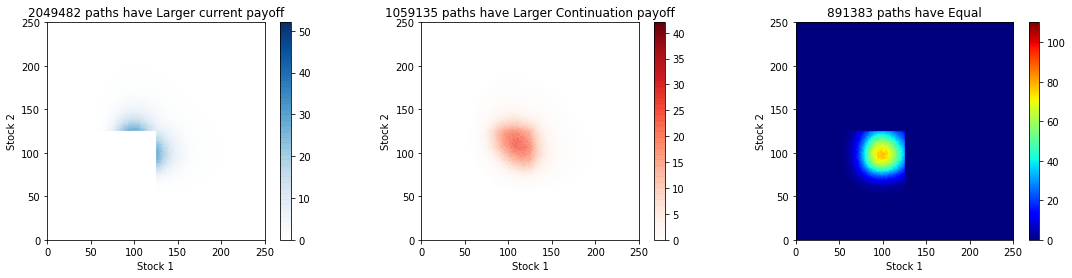

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (19,4))
xedges = np.linspace(0,200,1000)
yedges = np.linspace(0,200,1000)
area = ['Larger current payoff','Larger Continuation payoff','Equal']
color = ['Blues_alpha','Reds_alpha','jet']
size_check = cross_sec1.groupby("Signal").size() # Calculate the sum of paths by group
for i in range(3):
  x_,y_= cross_sec1.loc[cross_sec1.Signal==area[i], ["stock1","stock2"]].T.to_numpy()
  heatmap_, xedges_, yedges_ = np.histogram2d(x_, y_, bins=[xedges,yedges])
  h = ax[i].imshow(heatmap_.T, extent=extent, origin='lower', aspect = 'equal', cmap=color[i])
  ax[i].set(xlabel = 'Stock 1',ylabel='Stock 2',title=f'{size_check[i]} paths have {area[i]}')
  plt.colorbar(mappable = h, ax = ax[i])


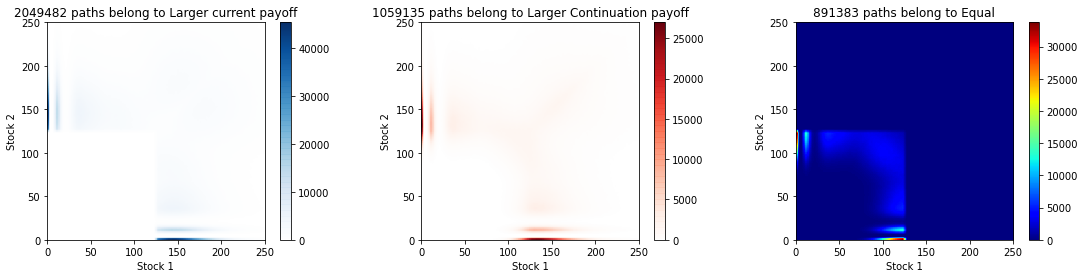

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (19,4))
xedges = np.linspace(0,200,100)
yedges = np.linspace(0,200,100)
area = ['Larger current payoff','Larger Continuation payoff','Equal']
color = ['Blues_alpha','Reds_alpha','jet']
size_check = cross_sec1.groupby("Signal").size() # Calculate the sum of paths by group
for i in range(3):
  x_,y_= cross_sec_IS.loc[cross_sec_IS.Signal==area[i], ["stock1","stock2"]].T.to_numpy()
  heatmap_, xedges_, yedges_ = np.histogram2d(x_, y_, bins=[xedges,yedges])
  h = ax[i].imshow(heatmap_.T, extent=extent, origin='lower', aspect = 'equal', cmap=color[i])
  ax[i].set(xlabel = 'Stock 1',ylabel='Stock 2',title=f'{size_check[i]} paths belong to {area[i]}')
  plt.colorbar(mappable = h, ax = ax[i])


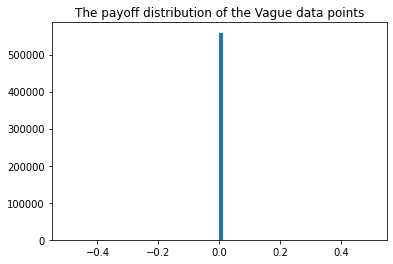

In [ ]:
# They are all below the strike price.
plt.hist(cross_sec1.loc[cross_sec1["Signal"]=='Vague',"current_payoff"], bins=80)
plt.title('The payoff distribution of the Vague data points')
plt.show()

<font color="red">Ask:</font>
OLS, entrophy loss etc ensures convergence of parameter $β$, how can we ensure this loss function makes our estimate for $(f_n)_{n\in N^+}$ converges.   
**Answer** This is rigorously proved in  (J. Han and W 2016). Convergence can be ensure for general Stochastic Problem which allows using Deep Learning algorithm.

# 3 Construct the neural network

##3.1 Custom loss function - a.k.a Empirical Risk Minimization 
With the current, continue payoff in place of shape `(M,2)`, what remains is to custom a loss funcition that takes the payoff as weights, note that this is very similar to the form of entrophy loss.

In [ ]:
decision_seq = np.zeros((int(M/5),N+1))
decision_seq[:,-1] = 1
decision_seq

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

The custom loss function is defined below. As in our unsupervised problem does not have `True label`, instead the `payoff` at time point n with shape **(batch_size, 2)** is passed as `y_true` - recall the 2 dimension correspond to the current payoff and the continue payoff. The batch size is the bottleneck of the GPU computation, it can handle about 500,000 samples at one time. Note that in the context of simulation based optimization, it is recommended to set the batch size to be too small (below 1000), since that results longer traing time and simply gives noisy gradients).

In [ ]:
from keras import backend as K
# Take the payoff as y_true, if keras check the shape in .fit, then I will have to reshape payoff as a tuple or sth.
def custom_loss(y_true, y_pred):
  if isinstance(y_true, np.ndarray):
    y_true = tf.constant(y_true, dtype=tf.float32)
  if isinstance(y_pred, np.ndarray):
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
  # The column 1 is the current payoff, the column 2 is the continue payoff
  current_payoff = tf.reshape(y_true[:,0],[-1,1])
  continue_payoff = tf.reshape(y_true[:,1],[-1,1])
  return tf.reduce_mean(-(current_payoff * y_pred + continue_payoff * (1 - y_pred)))

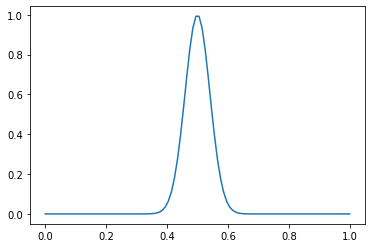

In [ ]:
x_pred_sim = np.linspace(0,1,100)
plt.plot(x_pred_sim, np.exp(-300*(x_pred_sim-0.5)*(x_pred_sim-0.5)))
plt.show()

Test the loss function by checking the gradients, we can see half of the samples having zero-gradiens as they are "Vague" - identical current and continue payoff.

In [ ]:
''' payoff = stock_draw.Option_payoff(1, 100, decision_seq)
y_true = payoff
y_pred = tf.convert_to_tensor(np.ones((int(M/5),1)),dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(y_pred)  # Start recording the history of operations applied to `a`
    # What's the gradient of `c` with respect to `a`?
    dc_da = tape.gradient(target=2*custom_loss(y_true, y_pred),sources=y_pred)
    hist, edges = np.histogram(dc_da, bins=100)  # THIS is faster than plt.hist
    plt.bar(x=(edges[:-1]+edges[1:])/2,height=hist, width=np.diff(edges))
    plt.show() '''

" payoff = stock_draw.Option_payoff(1, 100, decision_seq)\ny_true = payoff\ny_pred = tf.convert_to_tensor(np.ones((int(M/5),1)),dtype=tf.float32)\nwith tf.GradientTape() as tape:\n    tape.watch(y_pred)  # Start recording the history of operations applied to `a`\n    # What's the gradient of `c` with respect to `a`?\n    dc_da = tape.gradient(target=2*custom_loss(y_true, y_pred),sources=y_pred)\n    hist, edges = np.histogram(dc_da, bins=100)  # THIS is faster than plt.hist\n    plt.bar(x=(edges[:-1]+edges[1:])/2,height=hist, width=np.diff(edges))\n    plt.show() "

In [ ]:
tpu_strategy = None
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)

  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
  print('Not on TPU mode')

Not on TPU mode


##3.2 Designing the Architecture -- the symmetric case and Asymmetric case should be different.
Since the decision funciton $f_n(x_1,x_2)=f_n(x_2,x_1)$, the neural network should have the same weights for $x_1,x_2$, this is achieved by using `Keras.
To account for the symmetry property in for the decision funciton $f_n(x_1,x_2)=f_n(x2,x1)$ which result from both the symmetry of SDE and of the payoff function, we have actually two ways:  
**(a)** Permutate the inputs -- when sampling $x^m = (s_1,s_2)$, also add $x^{m'} = (s_2,s_1)$. This is absolutely doable, but will increase the size of training data significantly for high dimension case where we need to sample all the permuations of (s_1, s_2, ... , s_D) i.e. $A_D^D × M$ where $M$ is the original sample size, and $A_D^D=D!$. Even doing so, the symmetry is not 100% ensured.

**(b)** Symmetric Architecture ([Permutation Invariant](https://ai.stackexchange.com/questions/4655/how-could-we-build-a-neural-network-that-is-invariant-to-permutations-of-the-inp) ###[Another Reference](https://github.com/josefondrej/symmetric-layers/blob/master/symnn.py)): Another solution is to design an **REUSABLE UNIT**, reverse the data point in the neural network then takes the max out of the previous outputs. Another interesting thing one can try is using **Radial Basis Kernel** or other Hilber Kernel?

<font color='red'>It is very strange that sometimes the NN goes to a point that the optimization STOPs. I think it might be DEAD ReLu? </font>   
**[Batch Normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) MIGHT be useful!!**   
Reason: As the batches could be very different from each other, with different mean and variance, and causes the gradients to shift. Just to make the model more robust. (BUT stanford team points it out that it improves accuracy but cannot solve **INTERNAL COVARIATE SHIFT**)

On top of that, it is common to use between ReLu and Sigmoid layer as sigmoid are insensitive at the two end.

<font color='red'>[**Xavier Initializer**](https://www.deeplearning.ai/ai-notes/initialization/)  urges the nerons to learn differently! </font>  

In [ ]:
from keras import layers
from keras.layers import Lambda
# The Specify the if the problem is symmetric w.r.t D assets.
################
# Asymmetric 
################
def shuffle_layer(x, shuffled_index = [0,1]):
  input_transposed = tf.transpose(tf.gather(x,shuffled_index,axis=1), perm=[1,0])
  input_shuffled_transposed = tf.random.shuffle(input_transposed)
  input_shuffled = tf.transpose(input_shuffled_transposed, perm=[1,0])
  return tf.concat([input_shuffled,x[:,-1:]],axis=1)  # Put any variable besides x1,x2... in the last indices

def create_model(feature_num,time_step,case='symmetric_head'):
  # Resuable unit is shared for all cases.
  def reusable_unit():
    # Xavier Initializer
    initializer = tf.keras.initializers.GlorotNormal()
    input = keras.Input(shape=(feature_num,))  
    hidden = layers.Dense(30, activation = 'relu', kernel_initializer=initializer)
    out = hidden(input) # Out puts is of shape (1, 30)
    Model = keras.Model(input, out,name="Shared_ReLu")
    return Model

  if case =='shuffle':
    initializer = tf.keras.initializers.GlorotNormal()
    input = layers.Input(shape=(feature_num,))
    shuffle = Lambda(shuffle_layer, name = 'Shuffle')
    batch_norm1 = layers.BatchNormalization()
    batch_norm2 = layers.BatchNormalization()
    batch_norm3 = layers.BatchNormalization()
    hidden = layers.Dense(30, activation ='relu',name='ReLu_1',kernel_initializer=initializer)
    hidden2 = layers.Dense(30, activation ='relu',name='ReLu_2',kernel_initializer=initializer)
    combine = layers.Dense(1, activation = 'sigmoid',name='Sigmoid',kernel_initializer=initializer)
    output = combine(batch_norm3(hidden2(batch_norm2(hidden(batch_norm1(shuffle(input)))))))
    model_decision = keras.models.Model(input, output)
    return model_decision
  elif case == 'symmetric_head':
    # For Permutation Invariant case, f(x1,x2)=f(x2,x1)
    ##########################################
    # Symmetric by reverse and MaxPool #
    ##########################################
    # As I cant reverse neuron, I reverse the input x
    ##############################################################
    def batchnorm_symmetry_head(reusable_unit):
      # Xavier
      initializer = tf.keras.initializers.GlorotNormal()
      # Two batch_norm 
      batch_norm1 = layers.BatchNormalization()
      batch_norm2 = layers.BatchNormalization()
      input = keras.Input(shape=(feature_num,),name='D-Features') 
      # Permutate the data points
      rev = Lambda(lambda x: K.concatenate([x[:,1:], x[:, 0:1]], axis=1),name='Reverse')(input)
      r1 = reusable_unit(input)
      r2 = reusable_unit(rev)
      max_pool = layers.Maximum(name='Element_wise_Maximum')
      hidden3 = keras.layers.Dense(units=30, activation='relu',name='ReLu2',kernel_initializer=initializer)
      hidden4 = layers.Dense(1,activation='sigmoid',name='Sigmoid',kernel_initializer=initializer)
      output = hidden4(batch_norm2(hidden3(batch_norm1(max_pool([r1,r2])))))
      return input, output

    input, output = batchnorm_symmetry_head(reusable_unit())
    model_decision = keras.models.Model(input, output)
    return model_decision

  elif case == 'one_shot':
    input = keras.Input(shape=(time_step,feature_num,)) # And 1 dimension for time
    # Xavier
    initializer = tf.keras.initializers.GlorotNormal()
    batch_norm1 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_1'))
    batch_norm2 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_2'))
    batch_norm3 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_3'))
    shuffle = layers.TimeDistributed(Lambda(shuffle_layer, name = 'Shuffle'))
    hidden1 = layers.TimeDistributed(layers.Dense(units=30,activation='relu',name='ReLu1',kernel_initializer=initializer))
    hidden2 = layers.TimeDistributed(layers.Dense(units=30,activation='relu',name='ReLu2',kernel_initializer=initializer))
    combine = layers.TimeDistributed(layers.Dense(units=1,activation='sigmoid',name='Sigmoid',kernel_initializer=initializer))
    output = combine(batch_norm3(hidden2(batch_norm2(hidden1((batch_norm1(shuffle(input))))))))
    model_decision = keras.models.Model(input, output)
    return model_decision
  elif case == 'one_shot_asymmetric':
    input = keras.Input(shape=(time_step,feature_num,)) # And 1 dimension for time
    # Xavier
    initializer = tf.keras.initializers.GlorotNormal()
    batch_norm1 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_1'))
    batch_norm2 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_2'))
    batch_norm3 = layers.TimeDistributed(layers.BatchNormalization(axis=1,name = 'BN_3'))
    hidden1 = layers.TimeDistributed(layers.Dense(units=30,activation='relu',name='ReLu1',kernel_initializer=initializer))
    hidden2 = layers.TimeDistributed(layers.Dense(units=30,activation='relu',name='ReLu2',kernel_initializer=initializer))
    combine = layers.TimeDistributed(layers.Dense(units=1,activation='sigmoid',name='Sigmoid',kernel_initializer=initializer))
    output = combine(batch_norm3(hidden2(batch_norm2(hidden1((batch_norm1(input)))))))
    model_decision = keras.models.Model(input, output)
    return model_decision


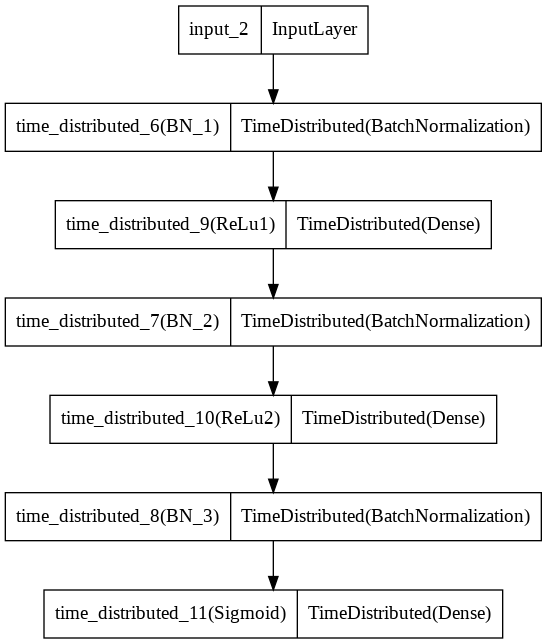

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(create_model(101,100,'one_shot_asymmetric'))

In [ ]:
create_model(101,100,'one_shot_asymmetric').summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 101)]        0         
                                                                 
 time_distributed_18 (TimeDi  (None, 100, 101)         404       
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 100, 30)          3060      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 100, 30)          120       
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 100, 30)          930       
 stributed)                                                

Define a funtion to initialize the Neural network and return decision made for each time point, starting from `n = N-1`  
Prepare the cross-sectional data by slicing `St_arr[:,n,:].copy()`, recall the sencond dimension corresponds to the time point n.

In [ ]:
def train_NN(X, y_true, feature_num, time_step, case = 'symmetric_head',batch_size = 1000000  ,learning_rate = 0.01, epochs=200, tpu_strategy = None):
  # Clear session
  tf.keras.backend.clear_session()
  # calculate new payoff
  # Multiplied by -1 represents the short selling.
  ###############################################################################################
  # The paths with the same current and continue payoff are left out of training #
  ###############################################################################################
  decision_seq_ = np.zeros(len(X), dtype=np.int8)
  useful_path = (y_true[:,0]!=y_true[:,1])
  X = X[useful_path,:]
  y_true = y_true[useful_path,:]
  decision_seq_[~useful_path] = 1
  print("==========================================================")
  # The number of paths that have greater current payoff than the continue payoff INDICATED by the network fitted backwards.
  geq_continue = np.sum(y_true[:,0]>y_true[:,1])
  print(f"At n = {n}, {len(y_true)} paths in training, {geq_continue} paths' have STRICTLY greater current payoff compared to the continue payoff (indicated by neural network.")
  #######################################################################################################################
  # Model Compile and Fit, initial learning rate can be specified, larger rate will "KILL" ReLu neurons
  #######################################################################################################################
  if tpu_strategy != None:
    with tpu_strategy.scope():
      adam_opt = tf.optimizers.Adam(learning_rate = learning_rate)
      model_ = create_model(feature_num, time_step, case)
      model_.compile(optimizer = adam_opt, loss = custom_loss)
  else:
    adam_opt = tf.optimizers.Adam(learning_rate = learning_rate)
    model_ = create_model(feature_num, time_step, case)
    model_.compile(optimizer = adam_opt, loss = custom_loss)
  history_ = model_.fit(X, y_true, batch_size=batch_size, shuffle = True, epochs = epochs, verbose = 1)
  stop_signals = (model_.predict(X, batch_size=batch_size).reshape(-1) >= 0.5)*1
  decision_seq_[useful_path] = stop_signals.astype(np.int8)
  print(f"The decision for n = {n} has been made, {np.sum(~useful_path)} paths are assigned MANUALLY Stop signal 1, {np.sum(stop_signals)} paths out of {np.sum(useful_path)} received stop signals")
  weights_ = model_.get_weights()

  return decision_seq_, weights_, history_

<font color="blue">Learining rate also matters,</font>
**I made a mistake that the Model can not be RETURNED!!!**

I am thinking add a **regularization FUNCTION over the pred**, to pernalize the vague decison between 0.2, 0.8 is POSSIBLY a good practice, like a Gaussian bell shape, if it is at the middle, then it is better?! What motivates me is that there is a time that even all paths see greater continue payoff, but it receives STOPPIng, (a screen shot in the Google drive folder). It gives 0.66, it might just be a symtop of inconvergence, but I think it doesnt hurt to add such a thing, worths a try.

In [ ]:
import time
start_time = time.time()
decision_seq = np.zeros((M,N+1), dtype=np.int8)
decision_seq[:,-1] = 1
# Note that the model can not be copied/cloned, but the weights can!!!
multi_s0_weights_dict = {}
history_dict = {}
model_ls = [None]*N
# The architecture of the model really matters!!!
# In total N * epochs, but the epochs here is much faster
for n in range(N-1,-1,-1):
  X = St_arr_multi[:,n,:].astype(np.float32) # Make a copy in case unexpected changes
  y_true = np.empty((M,2))
  for i in range(cluster_n):
    y_true[i*int(M/cluster_n):(i+1)*int(M/cluster_n)] = IS_dict['IS_instance'][i].Option_payoff(n,100,decision_seq[i*int(M/cluster_n):(i+1)*int(M/cluster_n)],weighted=True)
  y_true = y_true.astype(np.float32)
  decision_seq[:,n], multi_s0_weights_dict[n], history_dict[n] = train_NN(X, y_true, D, N, case = 'symmetric_head',batch_size=int(500000), learning_rate=0.005, epochs = 60, tpu_strategy=None)
  model_ls[n] = create_model(D, N, case = 'symmetric_head')
  model_ls[n].set_weights(multi_s0_weights_dict[n])
print("--- %s seconds ---" % (time.time() - start_time))

At n = 8, 19073082 paths in training, 10298603 paths' have STRICTLY greater current payoff compared to the continue payoff (indicated by neural network.
Epoch 1/60
39/39 [==============================] - 3s 40ms/step - loss: -25.8275
Epoch 2/60
39/39 [==============================] - 2s 40ms/step - loss: -26.0434
Epoch 3/60
39/39 [==============================] - 2s 39ms/step - loss: -26.0614
Epoch 4/60
39/39 [==============================] - 2s 39ms/step - loss: -26.0645
Epoch 5/60
39/39 [==============================] - 2s 39ms/step - loss: -26.0662
Epoch 6/60
39/39 [==============================] - 2s 40ms/step - loss: -26.0670
Epoch 7/60
39/39 [==============================] - 2s 39ms/step - loss: -26.0679
Epoch 8/60
39/39 [==============================] - 2s 40ms/step - loss: -26.0682
Epoch 9/60
39/39 [==============================] - 2s 39ms/step - loss: -26.0687
Epoch 10/60
39/39 [==============================] - 2s 40ms/step - loss: -26.0689
Epoch 11/60
39/39 [=======

# Specification
In total 1104.8957884311676 seconds: Using 1 millions batch-size, 20 million of samples in total, 80 epochs per NN, MANUALLY dispose zero-gradient samples. It takes about 900 seconds for finishing $\mathbf{N}$ NN's training. The rest are for Data preparation and trasforming the relaxed decision to feasible decison takes maybe 200 seconds? 


In [ ]:
# Calculate the practice payoff for n clusters
practice_payoff_cluster = IS_dict['IS_instance'][0].Option_payoff(0, 100, decision_seq[0:int(M/cluster_n),:], practice =True)
for i in range(1,cluster_n):
    practice_payoff_cluster = np.concatenate((practice_payoff_cluster, IS_dict['IS_instance'][i].Option_payoff(0,100,decision_seq[i*int(M/cluster_n):(i+1)*int(M/cluster_n),:],practice = True)), axis=0)

In [ ]:
practice_payoff_cluster.mean()

35.288357

In [ ]:
#print(f"The optimal expected payoff starting from n=0 is {stock_draw.Option_payoff(0,100,decision_seq,practice=True).mean()}")

**Using the <font color='red'>Batch Normalization</font> gives Better result!!!**

**Remark:** The architecture of the NN really Matters, Relu has a problem with dead Neuron/zero gradients. The batch normalization can handles the shift the previous activated value, for the nonlinear layers like Sigmoid, this adjustment make the values lie in the SWEET region.

It also allows larger range of learning rate which are good for avoid local minimum and gives Faster and Even better convergence.  

Larger batchsize makes the normalization less noisy.

In [ ]:
''' practice_payoff = np.zeros(N+1)
mean_payoff = np.zeros(N+1)
time = t/N * np.arange(0,N+1).reshape(-1,1)
for i in range(N,-1,-1):
  print(i)
  practice_payoff[i] = stock_draw.Option_payoff(i, 100, decision_seq, practice=True).mean()
  mean_payoff[i] = stock_draw.Option_payoff(i,100).mean()
plt.plot(time,-practice_payoff,"b*")
plt.plot(time,-mean_payoff,"r.")
plt.show() '''

' practice_payoff = np.zeros(N+1)\nmean_payoff = np.zeros(N+1)\ntime = t/N * np.arange(0,N+1).reshape(-1,1)\nfor i in range(N,-1,-1):\n  print(i)\n  practice_payoff[i] = stock_draw.Option_payoff(i, 100, decision_seq, practice=True).mean()\n  mean_payoff[i] = stock_draw.Option_payoff(i,100).mean()\nplt.plot(time,-practice_payoff,"b*")\nplt.plot(time,-mean_payoff,"r.")\nplt.show() '

## 3.3 Visualize the Tesselation/Boundary suggested by the Neural network

Note this is only reliable for the area where our data covers, the other area is by **Extrapolation**. The following is at n = 6, t = 3.

In [ ]:
# Create Cartesian Pairs!
grid_num = 1000
extent = np.array([0,200,0,200])
x = np.linspace(extent[0],extent[1],grid_num,dtype=np.float32)
y = np.linspace(extent[2],extent[3],grid_num,dtype=np.float32)
# Create Cartesian Pairs which forms a long form grid array (grid*grid,2)
X_test =  pd.DataFrame(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]), columns=['Stock 1','Stock 2'])

In [ ]:
for n in range(N):
  X_test['pred_prob'+str(n)] = model_ls[n].predict(X_test.loc[:,['Stock 1','Stock 2']], batch_size = 1000000)

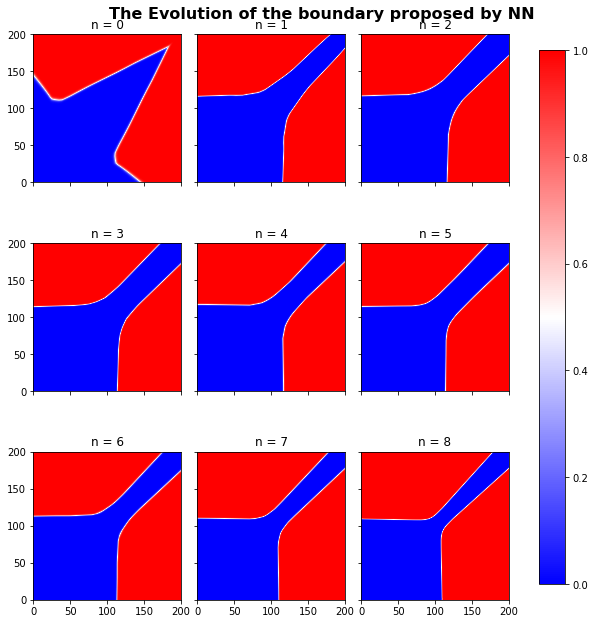

In [ ]:
fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize = (9,9),subplot_kw=dict(aspect=1))
ax = ax.flatten()
for n in range(N):
  h = ax[n].imshow(X_test['pred_prob'+str(n)].to_numpy().reshape((grid_num,grid_num)), origin='lower',cmap='bwr',extent=extent)
  ax[n].set(title=f'n = {n}')
fig.suptitle("The Evolution of the boundary proposed by NN",fontname='Courier', size=16,fontweight="bold")
plt.tight_layout()
fig.colorbar(h, ax=ax.ravel().tolist(), shrink = 0.9)
plt.show()

# 4 Prediction on Unseen data: The boundary or so-called Tesselation suggested by the NN
We can see that the boundary is almost linear and DOES NOT CHANGE?!?! which indicates a possible **UNDERFIT**, however the expected value is quite close to the value reported in the paper, I think it may be due to several possible reasons: 
1. The sample around the around the boundary are not enough, **Importance Sampling** is a possible solution. If this is a sampling problem, then tuning the algorithm is not of much use in my opininon.  

2. The Architecture is not flexible enough. A task to do is to implement Radial Basis Function, which can gives DEEP Support Vector Machine if lucky? For weird reason, the sometimes the Neural network with the same design fails to converge and stops at a certain point.

3. Shuffling the inputs is also worth a try.

In [ ]:
'''fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize = (9,9),subplot_kw=dict(aspect=1))
ax = ax.flatten()
for n in range(N):
  h = ax[n].hexbin(X_test['Stock 1'], X_test['Stock 2'], gridsize = (500,500) , C = X_test['pred_prob'+str(n)], cmap='bwr')
  ax[n].set(title=f'n = {n}') 
for n in range(N):
  h = ax[n].scatter(X_test['Stock 1'], X_test['Stock 2'], marker='.',s,c=X_test['pred_prob'+str(n)], cmap='bwr')
  ax[n].set(title=f'n = {n}') 
fig.suptitle("The Evolution of the boundary proposed by NN",fontsize=14)
fig.colorbar(h, ax=ax.ravel().tolist())
plt.show()  '''

'fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize = (9,9),subplot_kw=dict(aspect=1))\nax = ax.flatten()\nfor n in range(N):\n  h = ax[n].hexbin(X_test[\'Stock 1\'], X_test[\'Stock 2\'], gridsize = (500,500) , C = X_test[\'pred_prob\'+str(n)], cmap=\'bwr\')\n  ax[n].set(title=f\'n = {n}\') \nfor n in range(N):\n  h = ax[n].scatter(X_test[\'Stock 1\'], X_test[\'Stock 2\'], marker=\'.\',s,c=X_test[\'pred_prob\'+str(n)], cmap=\'bwr\')\n  ax[n].set(title=f\'n = {n}\') \nfig.suptitle("The Evolution of the boundary proposed by NN",fontsize=14)\nfig.colorbar(h, ax=ax.ravel().tolist())\nplt.show()  '

## Use the estimated sharp Boundary to decide for UNSEEN data. 

This is not IS, just a usage of Markov Property.

In [ ]:
# Predict on unseen data
decision_seq_BS = np.zeros((M_test,N+1), dtype=np.int8)
decision_seq_BS[:,-1] = 1
for n in range (N):
  decision_seq_BS[:,n] = (model_ls[n].predict(St_arr_BS[:,n,:], batch_size = 500000).reshape(-1)>=0.5)*1

9
8
7
6
5
4
3
2
1
0


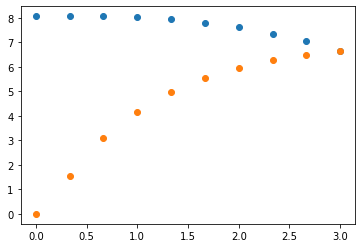

In [ ]:
practice_payoff_BS = np.zeros(N+1)
mean_payoff_BS = np.zeros(N+1)
time = t/N * np.arange(0,N+1).reshape(-1,1)
for i in range(N,-1,-1):
  print(i)
  practice_payoff_BS[i] = stock_BS.Option_payoff(i, 100, decision_seq_BS, practice=True).mean()
  mean_payoff_BS[i] = stock_BS.Option_payoff(i,100).mean()
plt.scatter(time, practice_payoff_BS)
plt.scatter(time, mean_payoff_BS)
plt.show() 

In [ ]:
practice_payoff_BS

array([8.06729031, 8.06729031, 8.06524181, 8.0345192 , 7.95050192,
       7.8100791 , 7.61615038, 7.35749912, 7.0415206 , 6.65131998])

## Struggle with Drive access: This goes back to the PARENT root, and allows remount!

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
if os.getcwd() == '/content':
  os.chdir('drive/My Drive/Colab Notebooks/project')

Mounted at /content/drive


In [ ]:
os.listdir()

['logs',
 'Pytorch_version.ipynb',
 'Checkpoint1-Find optimum with keras.ipynb',
 'data_generation.ipynb',
 'DOS.ipynb',
 '__pycache__',
 'fbm_model_weights',
 'fbm_weights_list.npy',
 'fbm_decison_seq0.npy',
 'dict_values.csv',
 'dict_values.json',
 'dict_values.npy',
 'full_dict_5_hurst.npy',
 'multi_s0_weights_dict.npy']

In [ ]:
from google.colab import files
files.download('multi_s0_weights_dict.npy')

In [ ]:
np.save('benchmark2.npy',multi_s0_weights_dict, allow_pickle=True)

In [ ]:
# np.load('20M_benchmark.npy', allow_pickle=True).item()

## Reload the model from weights

In [ ]:
model_ls = {}
N = 9
D = 2
for n in range(N):
  model_ls[n] = create_model(case = 'shuffle')
  model_ls[n].set_weights(multi_s0_weights_dict[n])


In [ ]:
model_ls[0].predict(np.array([90,90]).reshape((-1,2)))

array([[5.958667e-07]], dtype=float32)

# 5 One-shot fitting


$\mathbb{E}(∑_{n = 0}^{N}\mathbb{1}_{\tau_0=n}g(X_n)) = ∑_{n = 0}^{N}\mathcal{p}(τ=n)b_ng(X_n)$ where $b_i$ can be thought as buget, calculated by the product of the probability $∏_{i}^{n-1}(1-p_{i})$  .

## Custom a one-shot loss function
This is the only change compared to the previous work. The input
are readily available. As the VRAM will increas by N+1 times, this mthod is to trade time with storage.

In [ ]:
def loss_one_shot(y_true, y_pred):
  '''Return the loss of the batch under a set of weight
  Input
    y_true - ndarray: the payoff for in total N + 1 timepoints, converted to tensor automatically, of shape (batch_size, N+1, 1) # I may want to create a function for a convenient slicing.
    y_pred - tensor: shape (batch_size, N+1, 1)
  '''
  if isinstance(y_true, np.ndarray):
    y_true = tf.constant(y_true, dtype=tf.float32)
  budget_raw = tf.math.cumprod(1 - y_pred, axis=1)
  budget_N = budget_raw[:,-2:-1,:]  # keep dims by slicing
  budget_middle = budget_raw[:,:-2] # budget for 1,2,3,,,N-1
  # Reduce mean reduce the dimension to (N-1,1)     divided by 1*/batch_size
  middle_payoff = tf.reduce_sum(tf.reduce_mean(y_pred[:,1:-1] * budget_middle * y_true[:,1:-1], axis = 0))
  # p0 * 1 * g0 + bN * gN
  # Reduce mean reduce the dimension to (1,1)      divided by 1*/batch_size
  first_and_last_payoff = tf.reduce_sum(tf.reduce_mean(y_pred[:,0:1,:] * y_true[:,0:1,:] + budget_N * y_true[:,-1:,:], axis = 0))# Keep the dims by slicing instead of indexing, [batch_size, 1, 1]
  return -(middle_payoff + first_and_last_payoff)

In [ ]:
# Testing
y_true = tf.constant([[[100],[100],[100],[500]]],dtype=tf.float32)
y_pred = tf.constant([[[0.5],[0.5],[0.5],[0.5]]],dtype=tf.float32)
loss_one_shot(y_true,y_pred)
# 0.5**3 * 500 + (1-0.5**3)*100, -150 is correct h


<tf.Tensor: shape=(), dtype=float32, numpy=-150.0>

## data preparation and fit model

In [ ]:
time_sequence = np.tile(np.arange(N+1).reshape((-1,1)), (M,1,1))
X = None
gc.collect()
X = np.concatenate([St_arr_multi, time_sequence], dtype = np.float32, axis = 2)
y_true = payoff_full
print(f'The shape of training data is {X.shape}')
print(f'The shape of y_true is {y_true.shape}') # 20Million samples and 200000 batch size uses 15.48 Gb VRAM, 16.53 Gb CPU RAM.

The shape of training data is (30000000, 10, 4)
The shape of y_true is (30000000, 10, 1)


In [ ]:
IS_dict = None
St_arr_multi = None
time_sequence = None
decision_seq = None 
payoff_multi = None
cross_sec_IS = None
gc.collect()

0

In [ ]:
# We fit only one model here, much easier to organize.
# The architecture of the model really matters!!!
import time as timing_pkg
import keras.backend as K
K.clear_session()
start_time = timing_pkg.time()
one_shot_model = create_model(case = 'one_shot', feature_num = 4, time_step=10)
adam_opt = tf.optimizers.Adam(learning_rate = 0.001)
one_shot_model.compile(optimizer=adam_opt, loss=loss_one_shot)
one_shot_model.fit(X, y_true, batch_size = 100000, shuffle = True, epochs = 40)
one_shot_weights = one_shot_model.get_weights()
print("One-shot modelling uses --- %s seconds ---" % (timing_pkg.time() - start_time))
np.save('one_shot_weigts.npy',one_shot_weights)

Epoch 1/40
135/300 [============>.................] - ETA: 31s - loss: -20.3637

KeyboardInterrupt: ignored

In [ ]:
# Load from weights
one_shot_weights = np.load('one_shot_weigts.npy',allow_pickle=True)
one_shot_model = create_model(case = 'one_shot', feature_num = 4, time_step = 10)
one_shot_model.set_weights(one_shot_weights)

NameError: ignored

In [ ]:
# Dont forget to add time variate
# Create Cartesian Pairs!
grid_num = 2000
extent = np.array([0,200,0,200])
X_test_2D = None
X_test_3D = None
gc.collect()
x = np.linspace(extent[0],extent[1],grid_num,dtype=np.float32)
y = np.linspace(extent[2],extent[3],grid_num,dtype=np.float32)
time_seq = np.tile(np.arange(0,N+1).reshape((-1,1)),(grid_num**2,1,1))
# Create Cartesian Pairs which forms a long form grid array (grid*grid,2)
X_test_2D = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
X_test_3D = np.repeat(X_test_2D[:,np.newaxis,:], N, axis = 1)

In [ ]:
# Same location, but for different time, this matches the model input.
#X_test_with_time = np.concatenate([X_test_3D,time_seq], dtype = np.float32, axis = 2)
# Slicing is now the best.
#predicted_prob = one_shot_model.predict(X_test_with_time,batch_size=30000)
def payoff_all(St_arr, t, N, M, r, strike_price):
  max_spot_price = np.amax(St_arr,axis=2,keepdims=True).copy()
  payoff = np.maximum(max_spot_price - strike_price, 0, dtype=np.float32)

  time_grid = (t/N * np.tile(np.arange(0, N+1).reshape((-1,1)),(M,1,1))).astype(np.float32)
  discounting = np.exp(-r *time_grid, out = time_grid, dtype = np.float32)
  payoff = np.multiply(discounting, payoff, out = payoff)
  return payoff
# Get the map of the Tessalation, it makes more sense to overlap them, as it is less accurate for the later crossection, as they have small budget for the area that are allocated to the previous layer.
payoff_test = payoff_all(X_test_3D, t, N+1, grid_num**2, r, 100)
X_test_with_payoff = np.concatenate([X_test_3D, payoff_test,time_seq], dtype = np.float32, axis = 2)
predicted_prob = one_shot_model.predict(X_test_with_payoff, batch_size = 2000000)
predicted_prob[:,-1,:] = 1
budget_test = np.roll(np.cumprod(1-predicted_prob, axis = 1),shift=1,axis=1)
budget_test[:,0,:] = 1
# Starts from 1.
real_prob_test = np.multiply(budget_test, predicted_prob)

In [ ]:
predicted_prob.shape

## Visualize the result - has the ability to interpolate the timepoint in between

**This one shot method seems only produce reliable boundary for early timepoint! Think in this way, as our loss defined for $\tau_0$, if half of the samples are stopped before N-1, then N-1 has less budget, attached to it.**

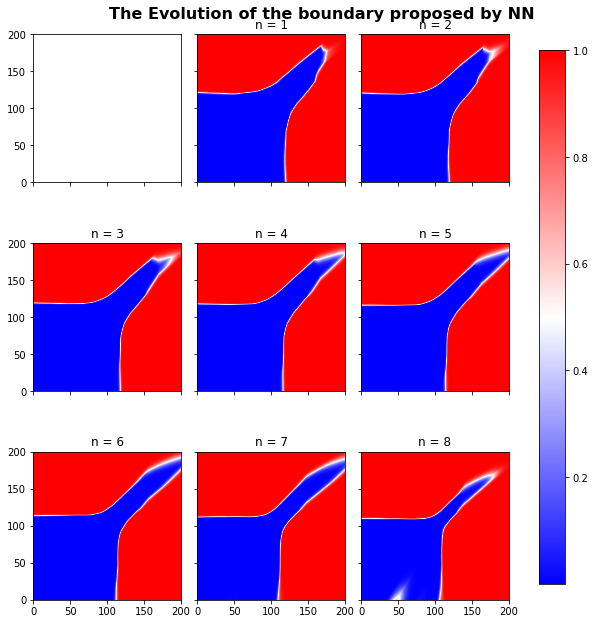

In [ ]:
fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize = (9,9),subplot_kw=dict(aspect=1))
ax = ax.flatten()
for n in range(1,N):
  h = ax[n].imshow(predicted_prob[:,n-1,:].reshape((grid_num,grid_num)), origin='lower',cmap='bwr',extent=extent)
  ax[n].set(title=f'n = {n}')
fig.suptitle("The Evolution of the boundary proposed by NN", size=16,fontweight="bold")
plt.tight_layout()
fig.colorbar(h, ax=ax.ravel().tolist(), shrink = 0.9)
plt.show()

The region that received early stopping, have very few weight for the continue region (gradient -> 0). If the boundary of the continuation are overlaid by the previous region, than the paths essential to learn this boundary will have few budget/weight, which result in the unreliable boundary. In the below plot, the NN see the same price, but different discounting. If a region shows the color corresponding time n, it shows that its probability is large, ortherwise, it could belongs to any stopping time/ undertrained because of under sampling.

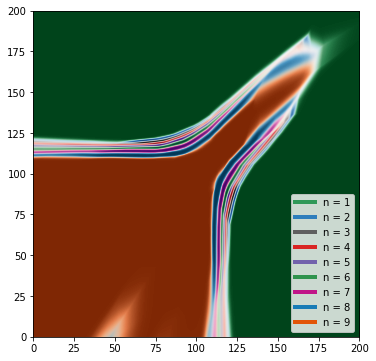

In [ ]:
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(0,N):
  ax.imshow(real_prob_test[:,i,:].reshape((grid_num,grid_num)), origin='lower',cmap = cmap_name[i]+'_alpha',extent=extent)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=get_cmap(cmap_name[i])(0.7), lw=4) for i in range(0,N)]
custom_labels = [f'n = {n}' for n in range(1,N+1)]
ax.legend(handles=custom_lines, labels = custom_labels, loc='lower right')
plt.show()

In [ ]:
get_cmap(cmap_name[6])(1)

(0.9997539407920031, 0.9657977700884275, 0.950234525182622, 1.0)

In [ ]:
payoff_BS = stock_BS.payoff_all(100)
time_seq = np.tile(np.arange(N+1).reshape((-1,1)),(M_test,1,1))
gc.collect()
X_BS_with_payoff = np.concatenate([St_arr_BS,payoff_BS,time_seq], dtype = np.float32, axis = 2)

In [ ]:
decision_sequence_test = 1*(one_shot_model.predict(X_BS_with_payoff, batch_size = 500000)>=0.5).reshape((-1,N+1))
decision_sequence_test[:,-1] = 1

In [ ]:
stock_BS.Option_payoff(2,100,decision_sequence_test,practice=True).mean()

8.068384

# 6 Fractional Brownian Motion

Procedure: 
By similarity property - $B(at) = aB(t)$, we can just sample $B(t)$,then scale it by $a$. By stationary property, $X_t = B(t)-B(s) \sim B(t-s)$  

Fractional Gaussian noise
Define the incremental process $X = f(X_k) : k = 0,1,....,N$ of fractional Brownian motion, which is called
fractional Gaussian noise, by  
$$X_k = B_H(k + 1) - B_H(k)$$
It is clear that X_k has a standard normal distribution for every k, but that there is (in general) no independence.  
To be precise, the corresponding autocovariance function is of the form 
$$Cov(X_i,X_{i+k})=γ(k) = \frac{1}{2}[|k-1|^{2H}+|k+1|^{2H}-2|k|^{2H}]$$

For programming implementation, the Fractional gaussian noise $X_k$ are firstly simulated for `M` sample paths using `numpy.multivariate_normal()`, then by `numpy.cumsum()` to derive the FBM, finally make it Markovian by enlarging state space, that is a FBM sample path transformed from shape (1, N+1) to (N+1, N) corresponding to the original paper.  

The functions for the above jobs are   
`FBM.fgn()`(use Cholesky method underhood) ----> `FBM.fbm()`----> `FBM.data_transformer()`  

Similar to the `Simulation` class for B-S sampling, the `FBM` class can calculate the current and continue payoff easily.


In [ ]:
import numpy as np
import gc
import matplotlib.pyplot as plt

class FBM(object):
  """The FBM class.
  After instantiating with n = number of increments, hurst parameter, length
  of realization (default = 1) and method of generation
  (default daviesharte), call fbm() for fBm, fgn()
  for fGn, or times() to get corresponding time values.
  """

  def __init__(self, N, hurst, length=1):
      """Instantiate the FBM."""
      self.N = N
      if hurst<0 or hurst>0.99999999:
        raise ValueError('Hurst parameter cannot be too close to 1, otherwise Cholesky decompositon fails')
      else:
        self.hurst = hurst
      self.length = length
      # Some reusable values to speed up Monte Carlo.
      self._cov = None
      self._eigenvals = None
      self._C = None
      self.scale = None
      self.fbm_draw = None
      self.fbm_arr = None
      gc_n = gc.collect()
      print(f'Clear {gc_n} garbage in initilization stage.')
  def __str__(self):
      """Str method."""
      return (
          "Sampling FBM using Cholesky on [0, "
          + str(self.length)
          + "] with Hurst value "
          + str(self.hurst)
          + " and "
          + str(self.N)
          + " increments"
      )

  def fbm(self, M_, draw_paths = 50):
      """Sample M paths at once."""
      # Release RAM
      fgn_sampled = None
      self.fbm_draw = None
      gc_n = gc.collect()
      print(f'Collecting {gc_n} garbage in self.fbm()')
      fgn_sampled = self.fgn(M_)
      fbm_sampled = np.insert(np.cumsum(fgn_sampled,axis=0,out=fgn_sampled), [0], values=0, axis=0).T
      # Use the first 50 samples for Visualization purpose
      if self.fbm_draw is None:
        self.fbm_draw = fbm_sampled[0:draw_paths,:].copy()
      return fbm_sampled

  def fgn(self, M_):
      """Sample the fractional Gaussian noise."""
      gn = None
      fgn_arr = None
      # Release RAM
      gc_n = gc.collect()
      # print(f'Collecting {gc_n} garbage in self.fgn()')
      # By the similarity property, FB(at) = a*FB(t) 
      self.scale = (1.0 * self.length / self.N) ** self.hurst
      # Shape (n,M)
      gn = np.random.multivariate_normal(np.zeros(self.N), np.eye(self.N),size=M_).astype(np.float32)
      gn = np.transpose(gn,(1,0))
      # If hurst == 1/2 then just return Gaussian noise
      assert gn.shape == (self.N, M_)
      if self.hurst == 0.5:
          return gn * self.scale
      else:
          fgn_arr = self._cholesky(gn)
          # Scale to interval [0, L]
          return fgn_arr * self.scale

  def times(self):
      """Get times associated with the fbm/fgn samples."""
      return np.linspace(0, self.length, self.N + 1)

  def _covariance(self, k):
      """Covariance for fgn."""
      return 0.5 * (abs(k - 1) ** (2 * self.hurst) - 2 * abs(k) ** (2 * self.hurst) + abs(k + 1) ** (2 * self.hurst))

  # For fractional Gaussian Noise
  def _cholesky(self, gn):
      """Generate a fgn realization using the Cholesky method.
      Uses Cholesky decomposition method (exact method) from:
      Asmussen, S. (1998). Stochastic simulation with a view towards
      stochastic processes. University of Aarhus. Centre for Mathematical
      Physics and Stochastics (MaPhySto)
      """
      # Monte carlo consideration
      fgn_arr = None
      gc.collect()
      if self._C is None:
          # Generate covariance matrix
          G = np.zeros([self.N, self.N])
          for i in range(self.N):
              for j in range(i + 1):
                  G[i, j] = self._covariance(i - j)

          # Cholesky decomposition
          self._C = np.linalg.cholesky(G)
      assert self._C.shape == (self.N, self.N)
      # Generate fgn, shape (M_,n,1)
      fgn_arr = np.matmul(self._C, gn, out=gn, dtype = np.float32)
      return fgn_arr

  def data_transformer(self, mat):
    '''Transform shape (M_, N+1) fbm sequence into shape (M_, N+1, N) - a Markovian process
    This is operated M times, the return value is a (M_,n+1,n) array.
    https://stackoverflow.com/questions/33700380/flip-non-zero-values-along-each-row-of-a-lower-triangular-numpy-array
    '''
    out = None
    fbm_mat = None
    gc.collect()
    # Reshape to (M_,1,n)
    fbm_mat = mat[:,np.newaxis,:]
    # Repeat the (1,n) row.
    fbm_mat = np.repeat(fbm_mat, self.N+1, axis =1)
    mask = np.tril(np.ones(fbm_mat.shape[1:3], dtype=bool))
    out = np.zeros_like(fbm_mat)
    out[:,mask] = fbm_mat[:,:,::-1][:,mask[:,::-1]]

    out = out[:,:,:-1].astype(np.float32)      
    # Release RAM
    del fbm_mat
    gc.collect()
    return out


  def simulate(self, M, draw_paths = 50):
    self.fbm_arr = None
    fbm_arr = None
    mat = None
    gc.collect()
    self.M = M
    if M <= 100000:
      # print("In simulate(): {gc_n} unreachable objects collected by GC")
      mat = self.fbm(M, draw_paths)
      fbm_arr = self.data_transformer(mat)
      self.fbm_arr = fbm_arr
    else:
      fbm_dict = None
      fbm_arr = None
      gc_n = gc.collect()
      # print(f"In simulate(): {gc_n} unreachable objects collected by GC")
      gc.collect()
      #fbm_dict = {i:self.data_transformer(self.fbm(50000, draw_paths)) for i in range(M//50000)}
      fbm_arr = np.empty((M,self.N+1,self.N), dtype=np.float32)
      for i in range(M//100000):
        fbm_arr[i*(100000):(i+1)*(100000),:,:] = self.data_transformer(self.fbm(100000, draw_paths))
        gc.collect()
      self.fbm_arr = fbm_arr

  def payoff(self, n, decision_seq = None, practice = False):
    if decision_seq is None:
      idx_0 = list(range(self.M))
      # np.exp(-self.r*n*self.t/self.N)* No discounting in this case, r = 0
      current_payoff = self.fbm_arr[idx_0,n,0].reshape((-1,1))
      return current_payoff

    if practice == False:
      payoff = None
      gc.collect()
      # To calculate continue payoff, check the decision sequence from n+1
      active_decision_seq = decision_seq[:, (n+1):(self.N+1)]
      # The expression of tn is equivalent to find the index of the first nonzero element starting from n+1
      tn = np.argmax(active_decision_seq, axis=1) + n+1
      decision_seq, active_decision_seq = None, None # Release RAM

      idx_0 = list(range(self.M))
      continue_payoff = self.fbm_arr[idx_0,tn,0].reshape((-1,1))
      current_payoff = self.fbm_arr[idx_0,n,0].reshape((-1,1))
      return np.column_stack((current_payoff,continue_payoff)) 
    else:
      optimal_payoff = None
      print("Collecting...")
      gc_n = gc.collect()
      # print("Number of unreachable objects collected by GC:", gc_n)
      # Find the index of the first nonzero element starting from n given a fully decided decision sequence
      active_decision_seq = decision_seq[:, n:(self.N+1)]
      tn = np.argmax(active_decision_seq, axis=1) + n
      decision_seq, active_decision_seq = None, None # Release RAM
      # Return the NN sugguested practice payoff
      idx_0 = list(range(self.M))
      optimal_payoff = self.fbm_arr[idx_0,tn,0].reshape((-1,1))
      return optimal_payoff.astype(np.float32)

  def payoff_all(self):
    return self.fbm_arr[:,:,0:1]


        



In [ ]:
# TO change parameter, just reinitialize.
M = 250000
N = 100
X = None
y_true = None
fbm_test = None
gc.collect()
fbm_test = FBM(N=100, hurst=0.01, length=1)
# 300,000 sequences will be converted to 300,000 * 101 * 100 array,
fbm_test.simulate(M, draw_paths = 100)

Clear 0 garbage in initilization stage.


Model fit, use 101 time steps, 100 features.

In [ ]:
X = None
y_true = None
print(gc.collect())
y_true = fbm_test.payoff_all()
X = fbm_test.fbm_arr


698


In [ ]:
fbm_one_shot = None
gc.collect()
tf.keras.backend.clear_session()
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            __:  1.5 GiB
                  St_arr_multi:  1.5 GiB
                           _35:  1.5 GiB
                           _41:  1.5 GiB
            decision_seq_multi:  1.5 GiB
                           _34:  1.5 GiB
                   payoff_full: 762.9 MiB
                  decision_seq: 190.7 MiB
                  payoff_multi: 152.6 MiB
                           _39: 152.6 MiB


## Fit One shot

In [ ]:
fbm_one_shot = create_model(100,101,'one_shot_asymmetric')
adam_opt = tf.optimizers.Adam(learning_rate=0.1)
fbm_one_shot.compile(optimizer=adam_opt,loss=loss_one_shot)
'''from numba import cuda
cuda.select_device(0)
cuda.close()'''

'from numba import cuda\ncuda.select_device(0)\ncuda.close()'

In [ ]:
fbm_one_shot.fit(X, y_true, batch_size=1000, epochs = 30, shuffle = True)

Epoch 1/30
250/250 [==============================] - 10s 23ms/step - loss: -1.0829
Epoch 2/30
250/250 [==============================] - 6s 22ms/step - loss: -1.1335
Epoch 3/30
250/250 [==============================] - 6s 22ms/step - loss: -1.1435
Epoch 4/30
250/250 [==============================] - 6s 23ms/step - loss: -1.1482
Epoch 5/30
250/250 [==============================] - 5s 22ms/step - loss: -1.1519
Epoch 6/30
250/250 [==============================] - 5s 22ms/step - loss: -1.1546
Epoch 7/30
250/250 [==============================] - 6s 23ms/step - loss: -1.1429
Epoch 8/30
250/250 [==============================] - 6s 23ms/step - loss: -1.1522
Epoch 9/30
250/250 [==============================] - 6s 22ms/step - loss: -1.1502
Epoch 10/30
250/250 [==============================] - 6s 22ms/step - loss: -1.1572
Epoch 11/30
250/250 [==============================] - 6s 23ms/step - loss: -1.1571
Epoch 12/30
250/250 [==============================] - 6s 22ms/step - loss: -1.1415
